<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# RAPIDS Evaluation

[RAPIDS](https://rapids.ai/about.html) is an open source software libraries and APIs to provide ability to execute end-to-end data science and analytics pipelines entirely on **GPU**. It is designed to have a familiar look and feel to data scientist working in Python. Our repository implements recommender's common evaluation metrics by utilizing RAPIDS [cuDF](https://docs.rapids.ai/api/cudf/stable/) to speed up the calculation so that users can use that if their computing environment meets the RAPIDS requirements. 

This notebook benchmarks speed of evaluation metric calculations based on Pandas DataFrame vs. cuDF DataFrame.

#### Requirements (v0.8)
* GPU: NVIDIA Pascal™ or better with compute capability 6.0+
  - Azure Data Science Virtual Machine (DSVM) [NC6v2](https://docs.microsoft.com/en-us/azure/virtual-machines/linux/sizes-gpu#ncv2-series) or [NC6v3](https://docs.microsoft.com/en-us/azure/virtual-machines/linux/sizes-gpu#ncv3-series) are good computing resources to start with 
* Supported OS: Ubuntu 16.04/18.04 or CentOS 7 with gcc 5.4 & 7.3
* To use docker - Docker CE v18+ and NVIDIA-docker v2+
* CUDA: 9.2 with driver v396.37+ or 10.0 with driver v410.48+
  - CUDA 10.1 is not supported in v0.8, support will be added soon
  
#### Installation
For now, recommender repository SETUP doesn't officially support RAPIDS environment because of the (relatively) hard requirements described above. To setup,
run following command on the machine that meets the requirement.
```
# TODO
```

## 0 Global settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
from statistics import mean, stdev
import math
import time

import cudf as cu
import numpy as np
import pandas as pd

from reco_utils.common.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
)
from reco_utils.common.plot import bar_chart
from reco_utils.common.gpu_utils import get_gpu_info
from reco_utils.dataset import movielens
from reco_utils.dataset.pandas_df_utils import user_item_pairs
from reco_utils.dataset.python_splitters import python_random_split
import reco_utils.evaluation.python_evaluation as pd_evaluator
import reco_utils.evaluation.rapids_evaluation as cu_evaluator

print(get_gpu_info(), "\n")
print("Pandas version: {}".format(pd.__version__))
print("CuDF version: {}".format(cu.__version__))

[{'device_name': 'Tesla V100-PCIE-16GB', 'total_memory': 16130.5, 'free_memory': 15711.625}] 

Pandas version: 0.24.2
CuDF version: 0.8.0+0.g8fa7bd3.dirty


In [3]:
MOVIELENS_DATA_SIZE = '1m'
REPEAT = 5

## 1 Prepare data

### 1.1 Prepare dummy data

For illustration purpose, a dummy data set is created for demonstrating how different evaluation metrics work. 

The data has the schema that can be frequently found in a recommendation problem, that is, each row in the dataset is a (user, item, rating) tuple, where "rating" can be an ordinal rating score (e.g., discrete integers of 1, 2, 3, etc.) or an numerical float number that quantitatively indicates the preference of the user towards that item. 

For simplicity reason, the column of rating in the dummy dataset we use in the example represent some ordinal ratings.

In [4]:
def load_movielens(size):
    pd_data = movielens.load_pandas_df(
        size=size,
        header=[USER_COL, ITEM_COL, RATING_COL],
    )
    
    items = pd_data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    users = pd_data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

    pd_pred = user_item_pairs(
        user_df=users,
        item_df=items,
        user_col=USER_COL,
        item_col=ITEM_COL,
    )
    pd_pred[PREDICT_COL] = pd.Series(np.random.randint(1, 6, size=len(pd_pred)), dtype='float32')
    
    print(
        "Num ratings = {}\n"
        "Num items = {}\n"
        "Num users = {}\n"
        "Num predictions = {}".format(len(pd_data), len(items), len(users), len(pd_pred))
    )
    
    return pd_data, pd_pred

In [5]:
pd_data, pd_pred = load_movielens(MOVIELENS_DATA_SIZE)
print("\nTrue data:\n", pd_data.head())
print("\nPrediction data:\n",pd_pred.head())

100%|██████████| 5.78k/5.78k [00:00<00:00, 22.4kKB/s]


Num ratings = 1000209
Num items = 3706
Num users = 6040
Num predictions = 22384240

True data:
    userID  itemID  rating
0       1    1193     5.0
1       1     661     3.0
2       1     914     3.0
3       1    3408     4.0
4       1    2355     5.0

Prediction data:
    userID  itemID  prediction
0    5405    1959         3.0
1    5080    1233         3.0
2    5973    2511         3.0
3    5972    2756         4.0
4    5188    3849         4.0


In [6]:
cu_data = cu.from_pandas(pd_data)
cu_pred = cu.from_pandas(pd_pred)

print(cu_data.head())
print(cu_pred.head())

   userID  itemID  rating
0       1    1193     5.0
1       1     661     3.0
2       1     914     3.0
3       1    3408     4.0
4       1    2355     5.0
   userID  itemID  prediction
0    5405    1959         3.0
1    5080    1233         3.0
2    5973    2511         3.0
3    5972    2756         4.0
4    5188    3849         4.0


## 2 Evaluation metrics

In [7]:
cols = [USER_COL, ITEM_COL, RATING_COL, PREDICT_COL]

In [8]:
def evaluate(fn, n, *args):
    """Evaluate fn n times"""
    start = time.time()
    metric = fn(*args)
    laps = [time.time() - start]
    for _ in range(n-1):
        start = time.time()
        assert math.isclose(metric, fn(*args), rel_tol=1e-06, abs_tol=1e-06)
        laps.append(time.time() - start)
    return metric, laps

### 2.1 Rating metrics

#### 2.1.1 Root Mean Square Error (RMSE)

In [9]:
pd_rmse, pd_rmse_times = evaluate(pd_evaluator.rmse, REPEAT, *[pd_data, pd_pred, *cols])
print("RMSE with Pandas = {}, took {} seconds in average".format(pd_rmse, mean(pd_rmse_times)))

RMSE with Pandas = 1.8919867496108722, took 29.030677461624144 seconds in average


In [10]:
cu_rmse, cu_rmse_times = evaluate(cu_evaluator.rmse, REPEAT, *[cu_data, cu_pred, *cols])
print("RMSE with Rapids.cuDF = {}, took seconds {} in average".format(cu_rmse, mean(cu_rmse_times)))

RMSE with Rapids.cuDF = 1.8919867496108722, took seconds 0.03458213806152344 in average


In [11]:
assert math.isclose(pd_rmse, cu_rmse, rel_tol=1e-06, abs_tol=1e-06)

#### 2.1.2 Mean Absolute Error (MAE)

In [12]:
pd_mae, pd_mae_times = evaluate(pd_evaluator.mae, REPEAT, *[pd_data, pd_pred, *cols])
print("MAE with Pandas = {}, took {} seconds in average".format(pd_mae, mean(pd_mae_times)))

MAE with Pandas = 1.5155192564753965, took 31.986706972122192 seconds in average


In [13]:
cu_mae, cu_mae_times = evaluate(cu_evaluator.mae, REPEAT, *[cu_data, cu_pred, *cols])
print("MAE with Rapids.cuDF = {}, took {} seconds in average".format(cu_mae, mean(cu_mae_times)))

MAE with Rapids.cuDF = 1.5155192564753965, took 0.03280062675476074 seconds in average


In [14]:
assert math.isclose(pd_mae, cu_mae, rel_tol=1e-06, abs_tol=1e-06)

#### 2.1.3 Summary

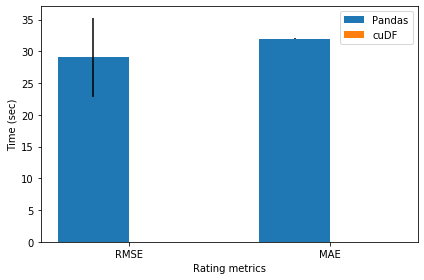

In [15]:
values = [
    [mean(pd_rmse_times), mean(pd_mae_times)],
    [mean(cu_rmse_times), mean(cu_mae_times)]
]
errors = [
    [stdev(pd_rmse_times), stdev(pd_mae_times)],
    [stdev(cu_rmse_times), stdev(cu_mae_times)]
]
labels = ['Pandas', 'cuDF']

bar_chart(values, labels, errors=errors, x_name="Rating metrics", y_name="Time (sec)", tick_labels=['RMSE', 'MAE'])

### 2.2 Ranking metrics

In [16]:
DEFAULT_K = 10
DEFAULT_THRESHOLD = 10

#### 2.2.1 Precision

In [17]:
pd_prec, pd_prec_times = evaluate(pd_evaluator.precision_at_k, REPEAT, *[pd_data, pd_pred, *cols, 'top_k', DEFAULT_K])
print("Precision at {} with Pandas = {}, took {} seconds in average".format(DEFAULT_K, pd_prec, mean(pd_prec_times)))

Precision at 10 with Pandas = 0.044735099337748364, took 32.028012895584105 seconds in average


In [18]:
cu_prec, cu_prec_times = evaluate(cu_evaluator.precision_at_k, REPEAT, *[cu_data, cu_pred, *cols, 'top_k', DEFAULT_K])
print("Precision at {} with Rapids.cuDF = {}, took {} seconds in average".format(DEFAULT_K, cu_prec, mean(cu_prec_times)))

Precision at 10 with Rapids.cuDF = 0.044735101358780005, took 1.015153455734253 seconds in average


In [19]:
assert math.isclose(pd_prec, cu_prec, rel_tol=1e-06, abs_tol=1e-06)

#### 2.2.2 Recall

In [20]:
pd_rec, pd_rec_times = evaluate(pd_evaluator.recall_at_k, REPEAT, *[pd_data, pd_pred, *cols, 'top_k', DEFAULT_K])
print("Recall at {} with Pandas = {}, took {} seconds in average".format(DEFAULT_K, pd_rec, mean(pd_rec_times)))

Recall at 10 with Pandas = 0.002697534436295761, took 31.74292302131653 seconds in average


In [21]:
cu_rec, cu_rec_times = evaluate(cu_evaluator.recall_at_k, REPEAT, *[cu_data, cu_pred, *cols, 'top_k', DEFAULT_K])
print("Recall at {} with Rapids.cuDF = {}, took {} seconds in average".format(DEFAULT_K, cu_rec, mean(cu_rec_times)))

Recall at 10 with Rapids.cuDF = 0.002697534436295761, took 0.8590415954589844 seconds in average


In [22]:
assert math.isclose(pd_rec, cu_rec, rel_tol=1e-06, abs_tol=1e-06)

In [23]:
type(cu_data)
isinstance(cu_data, cu.DataFrame)

True

#### 2.2.3 Normalized Discounted Cumulative Gain (NDCG)

In [24]:
pd_ndcg, pd_ndcg_times = evaluate(pd_evaluator.ndcg_at_k, REPEAT, *[pd_data, pd_pred, *cols, 'top_k', DEFAULT_K])
print("NDCG at {} with Pandas = {}, took {} seconds in average".format(DEFAULT_K, pd_ndcg, mean(pd_ndcg_times)))

NDCG at 10 with Pandas = 0.045403008092939505, took 32.04131827354431 seconds in average


In [25]:
cu_ndcg, cu_ndcg_times = evaluate(cu_evaluator.ndcg_at_k, REPEAT, *[cu_data, cu_pred, *cols, 'top_k', DEFAULT_K])
print("NDCG at {} with Rapids.cuDF = {}, took {} seconds in average".format(DEFAULT_K, cu_ndcg, mean(cu_ndcg_times)))

NDCG at 10 with Rapids.cuDF = 0.045403008092939505, took 1.2260494232177734 seconds in average


In [26]:
assert math.isclose(pd_ndcg, cu_ndcg, rel_tol=1e-06, abs_tol=1e-06)

#### 2.2.4 Mean Average Precision (MAP)

In [27]:
# TODO...

#### 2.2.5 Summary

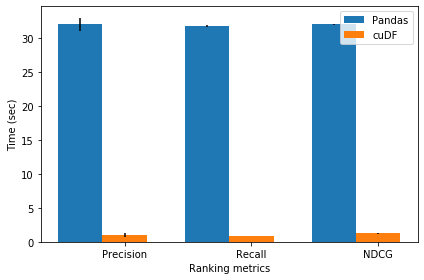

In [28]:
values = [
    [mean(pd_prec_times), mean(pd_rec_times), mean(pd_ndcg_times)],
    [mean(cu_prec_times), mean(cu_rec_times), mean(cu_ndcg_times)]
]

errors = [
    [stdev(pd_prec_times), stdev(pd_rec_times), stdev(pd_ndcg_times)],
    [stdev(cu_prec_times), stdev(cu_rec_times), stdev(cu_ndcg_times)]
]

labels = ['Pandas', 'cuDF']

bar_chart(values, labels, errors=errors, x_name="Ranking metrics", y_name="Time (sec)", tick_labels=['Precision', 'Recall', 'NDCG'])